# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

This code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Conclusions](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df_content.shape, df.shape

((1056, 5), (45993, 3))

In [4]:
print("DF Content ----------------")
print(df_content.dtypes)
print()

print("DF ------------------------")
print(df.dtypes)
print()

print("Seting type of df_content['article_id'] to str")
df_content['article_id'] = df_content.article_id.astype(float).astype(str)

print("Seting type of df['article_id'] to str")
df['article_id'] = df.article_id.astype(str)
print()

print("DF Content ----------------")
print(df_content.dtypes)
print()

print("DF ------------------------")
print(df.dtypes)
print()

DF Content ----------------
doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

DF ------------------------
article_id    float64
title          object
email          object
dtype: object

Seting type of df_content['article_id'] to str
Seting type of df['article_id'] to str

DF Content ----------------
doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id         object
dtype: object

DF ------------------------
article_id    object
title         object
email         object
dtype: object



Statistic of article counts by user
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


Text(0, 0.5, 'number of articles read')

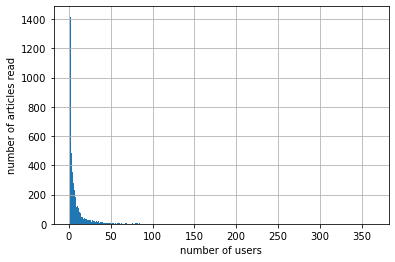

In [5]:
users_read_num_articles = df.groupby('email').article_id.count()
users_read_num_articles_stats = users_read_num_articles.describe()

print("Statistic of article counts by user")
print(users_read_num_articles_stats)
bin_range = np.arange(0, 364+1, 1)


ax = users_read_num_articles.hist(bins=bin_range)
ax.set_xlabel("number of users")
ax.set_ylabel("number of articles read")

95 (0.018453768453768452) users read more than 59.0 (mean + 3sigma) articles each


Text(0.5, 1.0, 'Truncated plot')

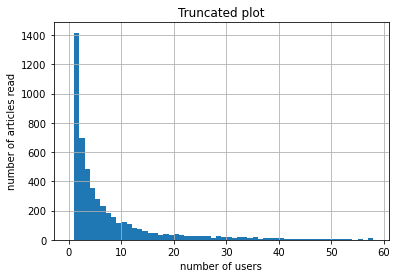

In [6]:
more_than_mu3sigma = np.floor(users_read_num_articles_stats['mean'] + 3 * users_read_num_articles_stats['std'])
num_users_more_than_mu3sigma = len(users_read_num_articles[users_read_num_articles > more_than_mu3sigma])

print("{} ({}) users read more than {} (mean + 3sigma) articles each".format(
    num_users_more_than_mu3sigma,
    num_users_more_than_mu3sigma / users_read_num_articles_stats['count'],
    more_than_mu3sigma))

bin_range = np.arange(0, more_than_mu3sigma, 1)

ax =users_read_num_articles.hist(bins=bin_range)
ax.set_xlabel("number of users")
ax.set_ylabel("number of articles read")
ax.set_title("Truncated plot")

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = users_read_num_articles.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = users_read_num_articles_stats['max'] # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles

df_content_article_counts = df_content.article_id.value_counts()
duplicate_article_ids = df_content_article_counts[df_content_article_counts > 1].index.tolist()

print("Duplicate articles sorted by article_id")
df_content[df_content['article_id'].isin(duplicate_article_ids)].sort_values('article_id')

Duplicate articles sorted by article_id


,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221.0
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221.0
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50.0
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50.0
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0


In [9]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates(subset=['article_id'], inplace=True)

print("Duplicate articles removed. Each article_id should appear only once.")
df_content[df_content['article_id'].isin(duplicate_article_ids)].sort_values('article_id')

Duplicate articles removed. Each article_id should appear only once.


,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221.0
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50.0
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df.article_id.unique().shape[0] # The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = df.dropna(subset=['email']).email.unique().shape[0] # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
sorted_articles_by_views = df.groupby('article_id').count().title.sort_values(ascending=False)

most_viewed_article_id = sorted_articles_by_views.index[0] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = sorted_articles_by_views.iloc[0] # The most viewed article in the dataset was viewed how many times?

print("Most often viewed  article is {} ({}) @ {} views".format(
    most_viewed_article_id, 
    df[df['article_id']==most_viewed_article_id].title.iloc[0],
    max_views))
      

Most often viewed  article is 1429.0 (use deep learning for image classification) @ 937 views


In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show headermost_viewed_article_id
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [14]:
# show top 5 articles (by interaction count)
df.groupby('article_id').count().title.sort_values(ascending=False).iloc[:5]

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: title, dtype: int64

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids = get_top_article_ids(n, df)
    
    top_articles = []
    for article_id in top_article_ids:
        # do not always use df[df[...] == ...], lets try something else
        title = df.query("article_id == '{}'".format(article_id)).iloc[0].title 
        top_articles.append(title)
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    sorted_articles_by_views = df.groupby('article_id').count().title.sort_values(ascending=False)
    top_articles = sorted_articles_by_views.index[:n]
 
    return top_articles # Return the top article ids


In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

print()
print("Top 5:")
print(top_5)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.

Top 5:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [17]:
# Try building the user-article/item matrix by grouping and unstacking.
# 
# apply fills with 1 if the interaction happend,
# rest of the values is NaN; fill those with 0.
df.iloc[:20].groupby(["user_id", "article_id"]).apply(lambda x: 1).unstack().fillna(0)

article_id,1170.0,1185.0,12.0,1276.0,1314.0,1338.0,1395.0,14.0,1429.0,1430.0,1432.0,173.0,542.0,593.0,993.0
user_id,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(["user_id", "article_id"]).apply(lambda x: 1).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [20]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    articles_of_user_id = user_item.loc[user_id]

    similar_users_user_id = []
    similar_users_dot = []
    for other_user_id in user_item.index:
        # remove the own user's id
        if other_user_id == user_id:
            continue

        articles_of_other_user = user_item.loc[other_user_id]
        dot = articles_of_user_id.dot(articles_of_other_user)

        similar_users_user_id.append(other_user_id)
        similar_users_dot.append(dot)

    # sort by similarity
    most_similar_users = pd.Series(similar_users_dot, index=similar_users_user_id).sort_values(ascending=False)

    # create list of just the ids
    return most_similar_users.index.tolist() # return a list of the users in order from most to least similar
        

In [21]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [22]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for article_id in article_ids:
        title = df.query("article_id == '{}'".format(article_id)).iloc[0].title
        article_names.append(title)
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    if not user_id in user_item.index.values:
        return [], []
    
    interactions_of_user = user_item.loc[user_id]
    
    article_ids = []
    for article_id, read in interactions_of_user.items():
        if read == 1.0:
            article_ids.append(article_id)
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def list_diff(first, second):
    if not second:
        return first
    
    second = set(second)
    return [item for item in first if item not in second]
    

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    article_ids_read = get_user_articles(user_id)[0]

    similar_user_ids = find_similar_users(user_id)
    recommended_article_ids = []
    for other_user_id in similar_user_ids:
        article_ids_read_by_other = get_user_articles(other_user_id)[0]
        new_articles = list_diff(article_ids_read_by_other, article_ids_read)
        new_articles = list_diff(new_articles, recommended_article_ids)

        recommended_article_ids += new_articles
        if len(recommended_article_ids) > m:
            break

    recs = recommended_article_ids[:m]
    
    return recs # return your recommendations for this user_id    

In [23]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [24]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''    
    # Handle new / unseen users
    articles_of_user_id = user_item.iloc[0] * 0 ## the layzy way, fake an series with all zeros and the correct article_ids as index
    if user_id in user_item.index.values:
         articles_of_user_id = user_item.loc[user_id]

    similar_users_user_id = []
    similar_users_similarity = []
    similar_users_interaction_count = []
    for other_user_id in user_item.index:
        # remove own user id (each user is similar to itselfe)
        if other_user_id == user_id:
            continue

        articles_of_other_user = user_item.loc[other_user_id]
        similarity = articles_of_user_id.dot(articles_of_other_user)
        interaction_count_of_other_user = articles_of_other_user.sum()

        similar_users_user_id.append(other_user_id)
        similar_users_similarity.append(similarity)
        similar_users_interaction_count.append(interaction_count_of_other_user)

    # sort by similarity
    neighbors_df = pd.DataFrame({'neighbor_id': similar_users_user_id,
                 'similarity': similar_users_similarity,
                 'num_interactions': similar_users_interaction_count})
    neighbors_df.set_index('neighbor_id')
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    article_ids_read = get_user_articles(user_id)[0]

    similar_user_ids = get_top_sorted_users(user_id)
    recommended_article_ids = []
    for other_user_id in similar_user_ids['neighbor_id']:
        article_ids_read_by_other = get_user_articles(other_user_id)[0]
        
        new_articles = list_diff(article_ids_read_by_other, article_ids_read) # remove already read articles
        new_articles = list_diff(new_articles, recommended_article_ids)  # remove already recommended articles

        # sort new articles by number of interactions
        df_article_sort_subset = df[df['article_id'].isin(new_articles)]
        new_articles = df_article_sort_subset.groupby('article_id').count().title.sort_values(ascending=False)
                        
        recommended_article_ids += new_articles.index.tolist()
        if len(recommended_article_ids) > m:
            break

    recs = recommended_article_ids[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [26]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [27]:
### Tests with a dictionary of results
user1_most_sim = int(get_top_sorted_users(1).iloc[0]['neighbor_id'])  # Find the user that is most similar to user 1 
user131_10th_sim = int(get_top_sorted_users(131).iloc[10]['neighbor_id'])  # Find the 10th most similar user to user 131

print("The user that is most similar to user 1:", user1_most_sim)
print("The user that is the 10th most similar to user 131: ", user131_10th_sim)

The user that is most similar to user 1: 3933
The user that is the 10th most similar to user 131:  242


In [28]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

***Possible Solutions***

A new user is a user with no article interactions. It is possible to use the `user_user_recs_part2` from above as it relies on the adapted version of `get_top_sorted_users`. `get_top_sorted_users` calculates the similarity of users (first sorting criterion) based on the dot product of the different user-item interactions of two users. As the new user has no interactions this dot product is going to be 0. Therefore the second (user with most total article interactions) and third (articles with most total interactions) sorting criterion determine the ranking. This kind of sorting assumes users with the most article interactions are some kind of user role model. This assumption does not appear to be very reasonable as it does not consider the quality of the articles.

A *better strategy*  might be, to recommend new users articles with higher total interaction counts. The underlying assumption is: articles with many interactions are popular. This can be accomplished with the function `get_top_articles`.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [29]:
new_user = 0.0

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
rec_ids, rec_names = user_user_recs_part2(new_user, 10)
new_user_recs = rec_ids  # Your recommendations here


In [30]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

***WARNING: This implementation is only a proof-of-concept and scales poorly (analysing many articles consumes a lot of time)***

*To get some ideas on how to improve this code please refere to the section [Extras & Conclusions](#conclusions).*

In [32]:
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from numpy import linalg as LA

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization

URL_REGEX = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
URL_PLACEHOLDER = "urlplaceholder"
STOP_STRINGS = ["...","\\r\\n\\r", ":"]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fsteppich\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fsteppich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fsteppich\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
def clean_with_regex(text, regex, replacement=""):
    detected_urls = re.findall(regex, text)
    for url in detected_urls:
        text = text.replace(url, replacement)
        
    return text
    

def tokenize(text):
    # Replace URLs with placeholder...
    text = clean_with_regex(text, URL_REGEX, URL_PLACEHOLDER)
    text = clean_with_regex(text, '[-!'']')

    tokens = word_tokenize(text.lower())    # normalize case
    tokens = [t.strip() for t in tokens]    # remove leading/trailing white space
    tokens = [t for t in tokens if t not in stopwords.words("english")]    
    tokens = [t for t in tokens if t not in STOP_STRINGS]   
    
    # Lemmatization...
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token, pos='v')
        clean_tokens.append(clean_token)

    return clean_tokens


# Train the Vectorizer
text = df_content.iloc[:200].doc_body   # <<<<<<<<<<<<<<<<<<<<<<<<<< ONLY PROOF-OF-CONCEPT (use full (training) set instead)
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=.6, max_features=200, min_df=.2, use_idf=True)
vectorizer.fit_transform(text)


<200x200 sparse matrix of type '<class 'numpy.float64'>'
	with 14760 stored elements in Compressed Sparse Row format>

In [34]:
def get_closest_articles(reference_article_ids, m=10, df_content=df_content):
    '''
    INPUT:
        reference_article_ids: list of reference articles.
        m: number of recommendations
        df_content: data frame used to retirve article data (text/body, title)
    
    OUTPUT:
        article_ids: list of article ids recommended based on the reference article id
        article_title: full name of the document matching the article_ids
        
    Description:
        This function finds articles close to a given list of reference_articles. 
        In order to accomplish this, the Bag-Of-Words (TfIdf) representation of the 
        reference_articles and all other articles get computed. To find the closest 
        articles the l2-norm of the difference of the Bag-Of-Words representations 
        gets computed. A low l2-norm is interpreted as close.
    '''
    article_ids = []
    distances = []
    doc_full_names = []
    for reference_article_id in reference_article_ids:
        reference_article_body = df_content[df_content['article_id'] == reference_article_id].doc_body
        reference_article_tfidf = vectorizer.transform(reference_article_body)
        
        for other_article_id in df_content.article_id.unique()[:100]:    # <<<<<<<<<< ONLY PROOF-OF-CONCEPT (use full set instead)
            if reference_article_id == other_article_id:
                continue
                
            other_article_row = df_content[df_content['article_id'] == other_article_id]
            other_article_body = other_article_row.doc_body
            if other_article_body is np.nan:
                continue
                
            other_article_tfidf = vectorizer.transform(other_article_body)
            
            distance_vector = (other_article_tfidf - reference_article_tfidf).todense()[0]
            distance = LA.norm(distance_vector)

            article_ids.append(other_article_id)
            distances.append(distance)
            doc_full_names.append(other_article_row.doc_full_name.values[0])

    distance_df = pd.DataFrame({'article_id': article_ids,
                                'distance': distances,
                                'doc_full_name': doc_full_names})
    distance_df.sort_values(by=['distance'], ascending=True, inplace=True)
    
    return distance_df.article_id[:m].values, distance_df.doc_full_name[:m].values


def make_content_recs(user_id, m=10, df=df, df_content=df_content):
    '''
    INPUT:
        user_id: recommend articles to this user
        m: number of recommendations
        df: data frame used to retirve top ranked articles (only in the case of a new user)
        df_content: data frame used to retirve article data (text/body, title)
    
    OUTPUT:
        rec_ids: list of article ids recommended based on the reference article id
        rec_titles: full name of the document matching the article_ids
    
    '''
    # recommend top articles if user is new
    if user_id not in df.user_id.values:
        rec_ids = get_top_article_ids(m, df).tolist()
        rec_titles = get_top_articles(m, df)
        return rec_ids, rec_titles
    
    article_read_by_user_ids, _ = get_user_articles(user_id)
    
    # find articles read by user
    rec_ids, rec_titles = get_closest_articles(article_read_by_user_ids, m, df_content)
    
    return rec_ids, rec_titles

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Explanation of your content based recommendation system**

1. Train a TfIdfVectorizer on a subset of all articles.
2. Find recommendations by comparing already read articles with unread articles. The ranking is based on the closeness (Euclidian distance, Manhatten distance, ...) of the two articles. Recommend the closest articles.
2. Cold Start Problem (new user): fall back to the rank-based approach

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [35]:
print("Finding article_ids seen in df_content and df ...")

df_content_aids = set(df_content.article_id.unique())
print("#IDs in df_content:", len(df_content_aids))
df_aids = set(df.article_id.unique())
print("#IDs in df:        ", len(df_aids))

aids_in_both_dfs = list(df_content_aids & df_aids)
print("#IDs in both:      ", len(aids_in_both_dfs))
print("   showing first 10:", aids_in_both_dfs[:10])

print("Is '1427.0' in both dfs? ", '1427.0' in aids_in_both_dfs)

Finding article_ids seen in df_content and df ...
#IDs in df_content: 1051
#IDs in df:         714
#IDs in both:       437
   showing first 10: ['861.0', '125.0', '40.0', '491.0', '504.0', '936.0', '524.0', '485.0', '892.0', '655.0']
Is '1427.0' in both dfs?  False


In [36]:
given_article_id = '1016.0'  # using another id as '1427.0' is not in both dataframes!
articles_read = user_item.sum(axis=1)

users_read_1 = articles_read == 1.0
users_read_given_article = user_item.loc[:, given_article_id] == 1.0
user_only_read_given_article = [a and b for a, b in zip(users_read_1.tolist(), users_read_given_article.tolist())]

print(f"Users that only read article {given_article_id} > \"{df_content[df_content['article_id'] == given_article_id].doc_full_name.values[0]}\"")
users_read_1[user_only_read_given_article]

Users that only read article 1016.0 > "Why you should master R (even if it might eventually become obsolete)"


user_id
1688    True
1797    True
dtype: bool

In [37]:
print("Make recommendations for a brand new user ...")
ids, titles = make_content_recs(0.0)
print("IDs:", ids)
print("Titles:", titles)
print()

# make a recommendations for a user who only has interacted with article id '1427.0'
# using another article id as 1427 is not in both dataframes (df, df_content)!
print("Make a recommendations for a user (1688) who only has interacted with article id '1016.0' ...")
ids, titles = make_content_recs(1688.0)
print("IDs:", ids)
print("Titles:", titles)


Make recommendations for a brand new user ...
IDs: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
Titles: ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']

Make a recommendations for a user (1688) who only has interacted with article id '1016.0' ...
IDs: ['89.0' '14.0' '87.0' '2.0' '1.0' '20.0' '76.0' '78.0' '73.0' '95.0']
Titles: ['Top 20 R Machine Learning and Data Science packages'
 'Got zip code data? Prep it for analytics. – IBM Watson Data Lab – Medium'
 'This Week in Data Scie

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [31]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [32]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

print("Number of nan values:", user_item_matrix.isna().sum().sum())

Number of nan values: 0


The DataFrame `user_item_matrix` does not contain any NaN values. This is due to the fact that the `user_item_matrix` encodes interactions between user and items/articles as a 1.0. A value of 0.0 encodes none-interactions.

NaN values in the matrix would require the application of an algorithm like FunkSVD to determine the matrix factorization.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

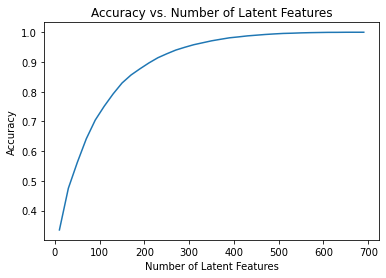

In [33]:
def plot_accuracy_vs_number_latent_features(user_item_matrix, s, u, vt, max_latent_features=700):
    num_latent_feats = np.arange(10,max_latent_features+10,20)
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    
    
plot_accuracy_vs_number_latent_features(user_item_matrix, s, u, vt)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [34]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts



user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [35]:
# Code to answer questions

def print_sol_4_dict_solutions(test_set, train_set, message_predictions, message_cold_start):
    in_testset = test_set.tolist()
    in_trainset = train_set.tolist()
    
    print(message_predictions, len(set(in_testset) & set(in_trainset)) )
    print(message_cold_start, len(in_testset) - len(set(in_testset) & set(in_trainset)) )
    
    
#in_testset = test_idx.tolist()
#in_trainset = user_item_train.index.tolist()

#in_testset = test_arts.tolist()
#in_trainset = user_item_train.columns.tolist()

#print( len(set(in_testset) & set(in_trainset)) )
#print( len(in_testset) - len(set(in_testset) & set(in_trainset)) )

print_sol_4_dict_solutions(test_idx, user_item_train.index, 
       'How many users can we make predictions for in the test set?', 
       'How many users in the test set are we not able to make predictions for because of the cold start problem?')

print_sol_4_dict_solutions(test_arts, user_item_train.columns, 
       'How many movies can we make predictions for in the test set?', 
       'How many movies in the test set are we not able to make predictions for because of the cold start problem?')


How many users can we make predictions for in the test set? 20
How many users in the test set are we not able to make predictions for because of the cold start problem? 662
How many movies can we make predictions for in the test set? 574
How many movies in the test set are we not able to make predictions for because of the cold start problem? 0


In [36]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [38]:
# fit SVD on the user_item_train matrix
common_users = user_item_train.index.intersection(test_idx)
common_articles = user_item_train.columns.intersection(test_arts)

common_user_idxs = user_item_train.index.isin(test_idx)
common_article_idxs = user_item_train.columns.isin(test_arts)

users_in_train_and_test = common_users
articles_in_train_and_test = common_articles

user_item_test_subset = user_item_test.loc[common_users, common_articles]
user_item_train_subset = user_item_train.loc[common_users, common_articles]

print("Shape of user_item_test_subset: ", user_item_test_subset.shape)

u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_test, s_test, vt_test = u_train[common_user_idxs, :], s_train, vt_train[:, common_article_idxs]

user_item_test_subset.head()

Shape of user_item_test_subset:  (20, 574)


article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
print("Number of articles read by user (in train subset):")
print(user_item_train_subset.sum(axis=1))
print()

print("Number of users read article ...")
article_interactions = user_item_train_subset.sum(axis=0)  # sum for each user
min_read_articles = 1
article_interactions_more_than = article_interactions[article_interactions >= min_read_articles]
print((len(article_interactions_more_than)/len(article_interactions) * 100), "% of the articles got read", min_read_articles, "or more times")
print(article_interactions_more_than)

print()
print("Statistics of these articles")
print(article_interactions_more_than.describe())

Number of articles read by user (in train subset):
user_id
2917    10.0
3024    26.0
3093    13.0
3193     1.0
3527     4.0
3532    20.0
3684    35.0
3740    20.0
3777     1.0
3801     8.0
3968    18.0
3989     1.0
3990     1.0
3998     2.0
4002     1.0
4204    20.0
4231     8.0
4274    16.0
4293    25.0
4487    14.0
dtype: float64

Number of users read article ...
27.177700348432055 % of the articles got read 1 or more times
article_id
1016.0    2.0
1017.0    1.0
1030.0    1.0
1035.0    1.0
1048.0    1.0
         ... 
975.0     1.0
977.0     2.0
98.0      1.0
990.0     1.0
996.0     1.0
Length: 156, dtype: float64

Statistics of these articles
count    156.000000
mean       1.564103
std        1.029748
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
dtype: float64


In [41]:
total_s_train = s_train.sum()
previous_covered_variability = 0
print("Using first n latant feature(s) explain p% of total variability")
for i in np.arange(10, s_train.shape[0]+1, 25):
    covered_variability = s_train[:i].sum() / total_s_train
    delta = covered_variability - previous_covered_variability
    print("  n={:2}, p={:.4}%, delta={:.3}%".format(i, covered_variability * 100, delta*100))
    previous_covered_variability = covered_variability 

Using first n latant feature(s) explain p% of total variability
  n=10, p=6.494%, delta=6.49%
  n=35, p=17.25%, delta=10.8%
  n=60, p=26.15%, delta=8.89%
  n=85, p=33.79%, delta=7.65%
  n=110, p=40.54%, delta=6.75%
  n=135, p=46.55%, delta=6.01%
  n=160, p=51.98%, delta=5.43%
  n=185, p=56.91%, delta=4.93%
  n=210, p=61.4%, delta=4.49%
  n=235, p=65.51%, delta=4.11%
  n=260, p=69.27%, delta=3.76%
  n=285, p=72.72%, delta=3.45%
  n=310, p=75.9%, delta=3.18%
  n=335, p=78.83%, delta=2.93%
  n=360, p=81.52%, delta=2.69%
  n=385, p=83.99%, delta=2.47%
  n=410, p=86.26%, delta=2.27%
  n=435, p=88.34%, delta=2.08%
  n=460, p=90.23%, delta=1.89%
  n=485, p=91.92%, delta=1.69%
  n=510, p=93.44%, delta=1.52%
  n=535, p=94.79%, delta=1.35%
  n=560, p=95.99%, delta=1.2%
  n=585, p=97.03%, delta=1.04%
  n=610, p=97.91%, delta=0.878%
  n=635, p=98.66%, delta=0.746%
  n=660, p=99.3%, delta=0.647%
  n=685, p=99.79%, delta=0.485%
  n=710, p=100.0%, delta=0.211%


About n=360 latent features should suffice to produce good results as these cover most (>80%) of the variability.

In [42]:
print("User <user_id> had ... article interaction(s) in train subset")
print(user_item_train_subset.sum(axis=1))
print()
        
print("User <user_id> had ... article interaction(s) in test subset")
print(user_item_test_subset.sum(axis=1))
print()

print("User <user_id> had ... different article interaction(s) in test compaired to train subset")
diffs = np.abs(np.subtract(user_item_test_subset, user_item_train_subset))
print(diffs.sum(axis=1))

User <user_id> had ... article interaction(s) in train subset
user_id
2917    10.0
3024    26.0
3093    13.0
3193     1.0
3527     4.0
3532    20.0
3684    35.0
3740    20.0
3777     1.0
3801     8.0
3968    18.0
3989     1.0
3990     1.0
3998     2.0
4002     1.0
4204    20.0
4231     8.0
4274    16.0
4293    25.0
4487    14.0
dtype: float64

User <user_id> had ... article interaction(s) in test subset
user_id
2917     2.0
3024     7.0
3093     5.0
3193     5.0
3527     1.0
3532    32.0
3684     3.0
3740    55.0
3777     1.0
3801    26.0
3968     8.0
3989     1.0
3990     1.0
3998     8.0
4002    10.0
4204     2.0
4231    16.0
4274     5.0
4293    26.0
4487     4.0
dtype: float64

User <user_id> had ... different article interaction(s) in test compaired to train subset
user_id
2917    12.0
3024    31.0
3093    16.0
3193     6.0
3527     5.0
3532    48.0
3684    36.0
3740    65.0
3777     2.0
3801    26.0
3968    24.0
3989     2.0
3990     2.0
3998    10.0
4002     9.0
4204    22.0
423

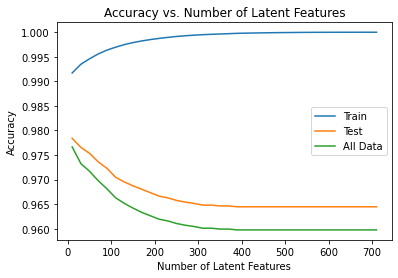

In [43]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

errs_train = []
errs_test = []
errs_all = []

num_latent_feats = np.arange(10, s_train.shape[0]+10,20)
for k in num_latent_feats:
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_lat, u_test_lat, vt_test_lat = np.diag(s_test[:k]), u_test[:, :k], vt_test[:k, :]
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_test_lat), vt_test_lat))
    
    diffs_all = np.sum(user_item_test_preds) + np.sum(np.sum(user_item_test_subset))
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_preds)
    
    err_all = diffs_all
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    errs_all.append(err_all)
    errs_train.append(err_train)
    errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), 
         label='Train');
plt.plot(num_latent_feats, 1 - np.array(errs_test)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]), 
         label='Test');
plt.plot(num_latent_feats, 1 - np.array(errs_all)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]), 
         label='All Data');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

***Solution***

**The Dataset**

27% of all articles (156 of the 574 articles in the intersection of train and test dataset; the total number of 714 articles) got read. This means the dataset is imbalanced. And only 20 users co-exist in the train and test dataset.

Those two facts imply the good accuracy values (>96%) of the evaluation phase. 

**Better Evaluation**

Better ways to evaluate the quality of the recommendations might be:
* **Elaborate train-test-split:** *Split training and test data in a way that maximizes the number of users and articles intersecting in both sets.*
* **Perform A/B-Testing:** *Split users cookie-driven or event-driven in two equally sized groups and analyze click count of the recommended articles. Event-driven splitting of users is possible in this case as a change in the recommendation engine does not impact the user experience like a change in the user interface.*
* **Let the user evaluate the quality (survey):** *A user gets a rating bar presented after reading the recommended article. Analyze at least the rating and article rank.*

## <a class="anchor" id="conclusions">Extras & Conclutions</a>

Before running any experiments it is necessary to put the code in a python module and allow the integration into the IBM Watson Studio platform. If integrating with the IBM Watson Studio platform is not possible, it might be possible to extract a current version of the dataset via API calls, perform and publish the recommendations on a web site, and/or a REST endpoint.

To improve the content-based recommendations it is useful to:
* modularize the code and make it testable,
* remove more none-word strings from the body (e.g. '\r', '\n', '...'),
* calculate and store the Bag-of-Words (TfIdf) representation of the documents, and
* perform the difference calculations in parallel.


In [44]:
# Export and store the html-Version locally

from subprocess import call
rc = call(['python', '-m', 'nbconvert', 'Recommendations.ipynb'])
if rc:
    print("Failed to convert notebook to html. RC =", rc)
else:
    print("Notebook converted successfully.")

Notebook converted successfully.
